In [2]:
import os
import glob
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt

In [3]:
# Run once to extract dataset from zip file
"""
import zipfile
import os

zip_path = "./scrabblegan_dataset.zip"  # Update with the actual filename
extract_path = "./dataset"

# Extract if not already extracted
if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

print("✅ Dataset extracted.")
"""

'\nimport zipfile\nimport os\n\nzip_path = "./scrabblegan_dataset.zip"  # Update with the actual filename\nextract_path = "./dataset"\n\n# Extract if not already extracted\nif not os.path.exists(extract_path):\n    with zipfile.ZipFile(zip_path, \'r\') as zip_ref:\n        zip_ref.extractall(extract_path)\n\nprint("✅ Dataset extracted.")\n'

In [4]:
# Deleting all corrupt files, run once after dataset is unzipped
"""
import os

folder_path = "C:\\Users\\jelly\\Desktop\\Sem-6\\GAN\\Project_Handwritten_Text_Generation\\dataset\\"
deleted_count = 0  # Counter for deleted files

for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)
    if os.path.getsize(file_path) == 0:  # Check if file is empty
        print(f"❌ Deleting empty file: {filename}")
        os.remove(file_path)
        deleted_count += 1  # Increment counter

print(f"✅ All empty files deleted! Total files deleted: {deleted_count}")
"""

'\nimport os\n\nfolder_path = "C:\\Users\\jelly\\Desktop\\Sem-6\\GAN\\Project_Handwritten_Text_Generation\\dataset\\"\ndeleted_count = 0  # Counter for deleted files\n\nfor filename in os.listdir(folder_path):\n    file_path = os.path.join(folder_path, filename)\n    if os.path.getsize(file_path) == 0:  # Check if file is empty\n        print(f"❌ Deleting empty file: {filename}")\n        os.remove(file_path)\n        deleted_count += 1  # Increment counter\n\nprint(f"✅ All empty files deleted! Total files deleted: {deleted_count}")\n'

In [5]:
from torch.utils.data import Dataset
import glob
from PIL import Image
import torchvision.transforms as transforms

class HandwritingDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform

        # Collect paired images (printed -> handwritten)
        self.pairs = []
        printed_images = glob.glob(os.path.join(root_dir, "**", "*_printed.png"), recursive=True)

        for printed in printed_images:
            handwritten = printed.replace("_printed.png", "_handwritten.png")
            if os.path.exists(handwritten):
                self.pairs.append((printed, handwritten))

        if len(self.pairs) == 0:
            raise ValueError("❌ No paired images found! Check dataset structure.")

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        printed_path, handwritten_path = self.pairs[idx]

        printed_img = Image.open(printed_path).convert("L")
        handwritten_img = Image.open(handwritten_path).convert("L")

        if self.transform:
            printed_img = self.transform(printed_img)
            handwritten_img = self.transform(handwritten_img)

        return printed_img, handwritten_img

In [6]:
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((32, 128)),  # Resize to consistent dimensions
    transforms.ToTensor(),          
    transforms.Normalize((0.5,), (0.5,))  
])

In [7]:
dataset = HandwritingDataset(root_dir="./dataset", transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

print(f"✅ Dataset loaded with {len(dataset)} samples.")

✅ Dataset loaded with 44563 samples.


In [8]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += residual  # Skip connection
        out = self.relu(out)
        return out

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )

        self.res_blocks = nn.Sequential(*[ResidualBlock(64) for _ in range(8)])  # 8 residual layers

        self.final = nn.Sequential(
            nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.initial(x)
        x = self.res_blocks(x)
        x = self.final(x)
        return x

In [9]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            nn.Conv2d(512, 1, kernel_size=3, stride=1, padding=1),
            nn.Flatten(),
            nn.Linear(4 * 16 * 1, 1)  # Adjust for input size 32x128
        )

    def forward(self, x):
        return self.model(x)

In [10]:
"""
# ===================== Generator =====================
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        layers = [
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        ]

        # 48 Additional Conv Layers
        for _ in range(8):
            layers.append(nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1))
            layers.append(nn.BatchNorm2d(64))
            layers.append(nn.ReLU())

        layers.append(nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1))
        layers.append(nn.Tanh())  # Normalize output to [-1, 1]

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# ===================== Discriminator =====================
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        layers = [
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2)
        ]

        # 48 Additional Conv Layers
        for _ in range(8):
            layers.append(nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1))
            layers.append(nn.BatchNorm2d(64))
            layers.append(nn.LeakyReLU(0.2))

        layers.append(nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1))
        layers.append(nn.Flatten())

        # Adjust Linear Layer for (64, 256) input shape
        layers.append(nn.Linear(32 * 128, 1))

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)
"""

'\n# ===================== Generator =====================\nclass Generator(nn.Module):\n    def __init__(self):\n        super(Generator, self).__init__()\n\n        layers = [\n            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),\n            nn.ReLU()\n        ]\n\n        # 48 Additional Conv Layers\n        for _ in range(8):\n            layers.append(nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1))\n            layers.append(nn.BatchNorm2d(64))\n            layers.append(nn.ReLU())\n\n        layers.append(nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1))\n        layers.append(nn.Tanh())  # Normalize output to [-1, 1]\n\n        self.model = nn.Sequential(*layers)\n\n    def forward(self, x):\n        return self.model(x)\n\n# ===================== Discriminator =====================\nclass Discriminator(nn.Module):\n    def __init__(self):\n        super(Discriminator, self).__init__()\n\n        layers = [\n            nn.Conv2d(1, 64, kernel_size=3, st

In [11]:
"""def gradient_penalty(D, real_samples, fake_samples, device="cuda"):
    alpha = torch.rand(real_samples.size(0), 1, 1, 1).to(device)
    interpolated = (alpha * real_samples + (1 - alpha) * fake_samples).requires_grad_(True)

    critic_interpolates = D(interpolated)
    gradients = torch.autograd.grad(outputs=critic_interpolates, inputs=interpolated,
                                    grad_outputs=torch.ones_like(critic_interpolates),
                                    create_graph=True, retain_graph=True)[0]

    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty
"""
def gradient_penalty(D, real_samples, fake_samples, device="cuda"):
    alpha = torch.rand(real_samples.size(0), 1, 1, 1, device=device)
    interpolated = (alpha * real_samples + (1 - alpha) * fake_samples).requires_grad_(True)

    critic_interpolates = D(interpolated)
    gradients = torch.autograd.grad(
        outputs=critic_interpolates,
        inputs=interpolated,
        grad_outputs=torch.ones_like(critic_interpolates),
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]

    # Compute gradient norm
    grad_norm = gradients.view(gradients.size(0), -1).norm(2, dim=1)
    #print(f"Mean Gradient Norm: {grad_norm.mean().item()}")  # Debugging

    return ((grad_norm - 1) ** 2).mean()

In [15]:
del generator, discriminator
torch.cuda.empty_cache()

In [12]:
import torch.optim as optim

device = "cuda" if torch.cuda.is_available() else "cpu"

generator = Generator().to(device)
discriminator = Discriminator().to(device)

#Consider using (0.0, 0.9) as betas for more stable training
optimizer_G = optim.Adam(generator.parameters(), lr=0.0001, betas=(0.5, 0.9))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.5, 0.9))

# Consider using RMSprop optimizer as used with original WGAN
"""
optimizer_G = optim.RMSprop(generator.parameters(), lr=0.00005)
optimizer_D = optim.RMSprop(discriminator.parameters(), lr=0.00005)
"""

#Consider lowering this value, as it might be reducing the impact of wassertein loss itself
lambda_gp = 40  # Gradient penalty weight

In [12]:
from tqdm import tqdm

num_epochs = 50  # Number of training epochs

for epoch in range(num_epochs):
    progress_bar = tqdm(dataloader, total=len(dataloader), desc=f"Epoch {epoch+1}/{num_epochs}")

    for i, (printed_imgs, handwritten_imgs) in enumerate(progress_bar):
        printed_imgs = printed_imgs.to(device, non_blocking=True)
        handwritten_imgs = handwritten_imgs.to(device, non_blocking=True)

        # ==================== Train Discriminator ====================
        optimizer_D.zero_grad()

        real_pred = discriminator(handwritten_imgs)
        fake_imgs = generator(printed_imgs).detach()
        fake_pred = discriminator(fake_imgs)

        gp = gradient_penalty(discriminator, handwritten_imgs, fake_imgs, device)
        d_loss = -torch.mean(real_pred) + torch.mean(fake_pred) + lambda_gp * gp

        d_loss.backward()
        optimizer_D.step()

        # ==================== Train Generator ====================
        g_loss_value = None
        if i % 2 == 0:  # Train generator less frequently
            optimizer_G.zero_grad()

            fake_imgs = generator(printed_imgs)
            fake_pred = discriminator(fake_imgs)

            g_loss = -torch.mean(fake_pred)

            g_loss.backward()
            optimizer_G.step()

            g_loss_value = g_loss.item()

        # ==================== Update tqdm ====================
        progress_bar.set_postfix({
            "D Loss": f"{d_loss.item():.4f}",
            "G Loss": f"{g_loss_value:.4f}" if g_loss_value else "Skipping"
        })

        # ==================== Free GPU Memory (Only After Both Updates) ====================
        del real_pred, fake_imgs, fake_pred, gp, handwritten_imgs, d_loss
        if g_loss_value is not None:
            del g_loss
        torch.cuda.empty_cache()

C:\Users\jelly\anaconda3\envs\pytorch_env\Lib\site-packages\torch\autograd\graph.py:768: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\cuda\CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Epoch 50/50: 100%|██████████| 2786/2786 [05:46<00:00,  8.05it/s, D Loss=-15.3589, G Loss=Skipping]    


In [13]:
torch.save({'generator': generator.state_dict(), 'discriminator': discriminator.state_dict()}, "model_checkpoint.pth")

### Loading saved model

In [17]:
import torch

# Define your models first
generator = Generator().to(device)  # Replace with your actual generator class
discriminator = Discriminator().to(device)  # Replace with your actual discriminator class

# Load the checkpoint
checkpoint = torch.load("model_checkpoint.pth")

# Load the saved state dictionaries
generator.load_state_dict(checkpoint['generator'])
discriminator.load_state_dict(checkpoint['discriminator'])

C:\Users\jelly\AppData\Local\Temp\ipykernel_3708\1404931236.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("model_checkpoint.pth")


<All keys matched successfully>

In [ ]:
from PIL import Image, ImageDraw, ImageFont
import torch
import torchvision.transforms as transforms

# Load font (make sure the path to your font file is correct)
font_path = "arial.ttf"  # Change to the actual font file path
font_size = 40
font = ImageFont.truetype(font_path, font_size)

# Function to create a printed text image
def text_to_input_image(text, img_size=(300, 100)):
    img = Image.new("RGB", img_size, "white")
    draw = ImageDraw.Draw(img)
    draw.text((10, 30), text, font=font, fill="black")
    
    # Resize to match the model input (32 x 128) and convert to grayscale
    transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize((32, 128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize to match training distribution
    ])

    input_tensor = transform(img).unsqueeze(0)  # Add batch dimension
    return input_tensor.to("cuda" if torch.cuda.is_available() else "cpu")  # Move to GPU if available

# Function to generate handwritten text image
def generate_handwritten_image(text):
    input_image_tensor = text_to_input_image(text)

    # Generate handwritten image
    with torch.no_grad():
        handwritten_tensor = generator(input_image_tensor)  # Pass through the trained generator

    # Convert output tensor to image
    handwritten_tensor = handwritten_tensor.squeeze(0).cpu()  # Remove batch dimension and move to CPU
    handwritten_tensor = (handwritten_tensor * 0.5) + 0.5  # Denormalize from [-1,1] to [0,1]

    # Convert tensor to PIL image
    handwritten_image = transforms.ToPILImage()(handwritten_tensor)

    return handwritten_image

Image for 'Random': 


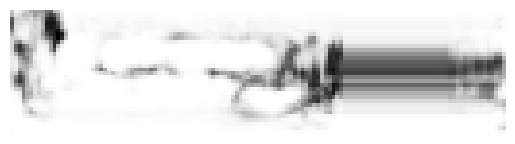

Image for 'The': 


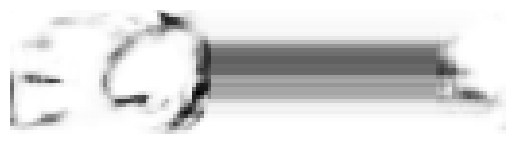

Image for 'Keys': 


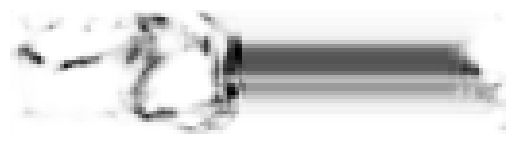

In [31]:
# Example usage
text = ["Random", "The", "Keys"]

for text in text:
    handwritten_image = generate_handwritten_image(text)
    print(f"Image for '{text}': ")
    # Show image
    plt.imshow(handwritten_image, cmap="gray")
    plt.axis("off")
    plt.show()